In [35]:
import tensorflow as tf
from keras import datasets, layers, callbacks, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
tf.config.list_physical_devices('GPU')

[]

In [37]:
series = np.sin((0.1*np.arange(400))**2)

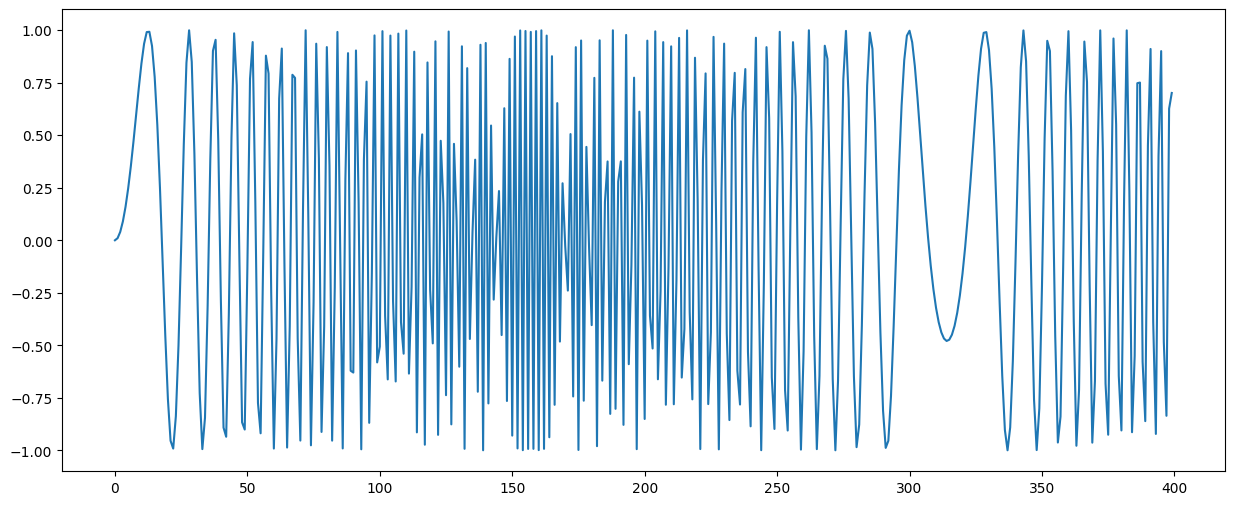

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(series)
plt.show()

In [39]:
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)

print('X shape:', np.array(X).shape)
print('Y shape:', np.array(Y).shape)

X shape: (390, 10)
Y shape: (390,)


In [40]:
test_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

print(test_matrix[1:2])
print(test_matrix[0:-2])
print(test_matrix[-2:])
print(test_matrix[2:])
print()
print(test_matrix[:, 0])
print(test_matrix[:, 0:2])

[[4 5 6]]
[[1 2 3]]
[[4 5 6]
 [7 8 9]]
[[7 8 9]]

[1 4 7]
[[1 2]
 [4 5]
 [7 8]]


In [41]:
# try autoregressive linear model
i = layers.Input(shape=(T,))
x = layers.Dense(1)(i)
model = models.Model(i, x)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='mse'
)

r_autoregressive = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
    verbose=0
)

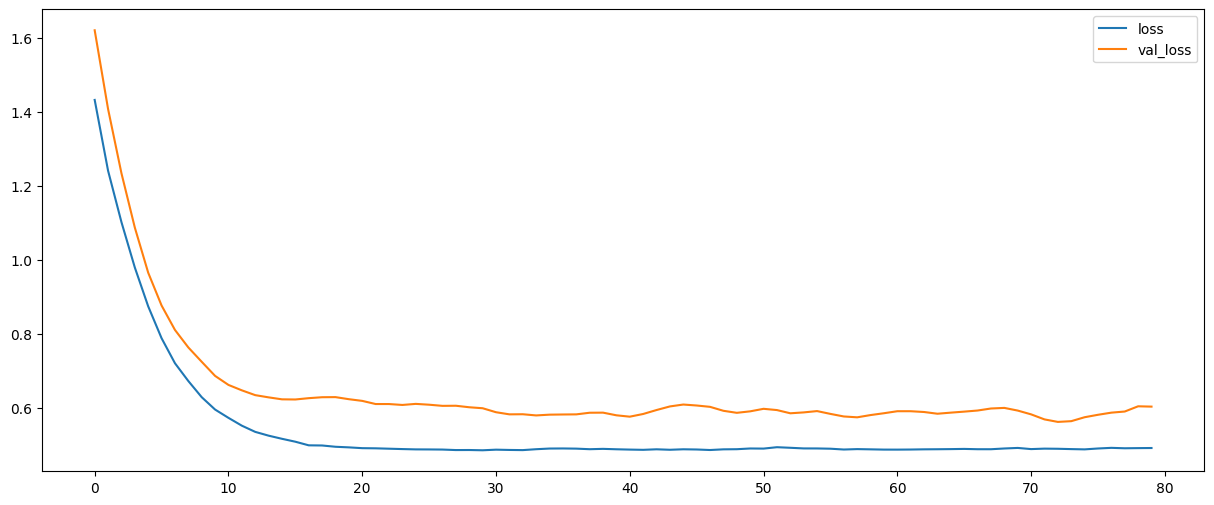

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(r_autoregressive.history['loss'], label='loss')
plt.plot(r_autoregressive.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(390, 1)
(390,)


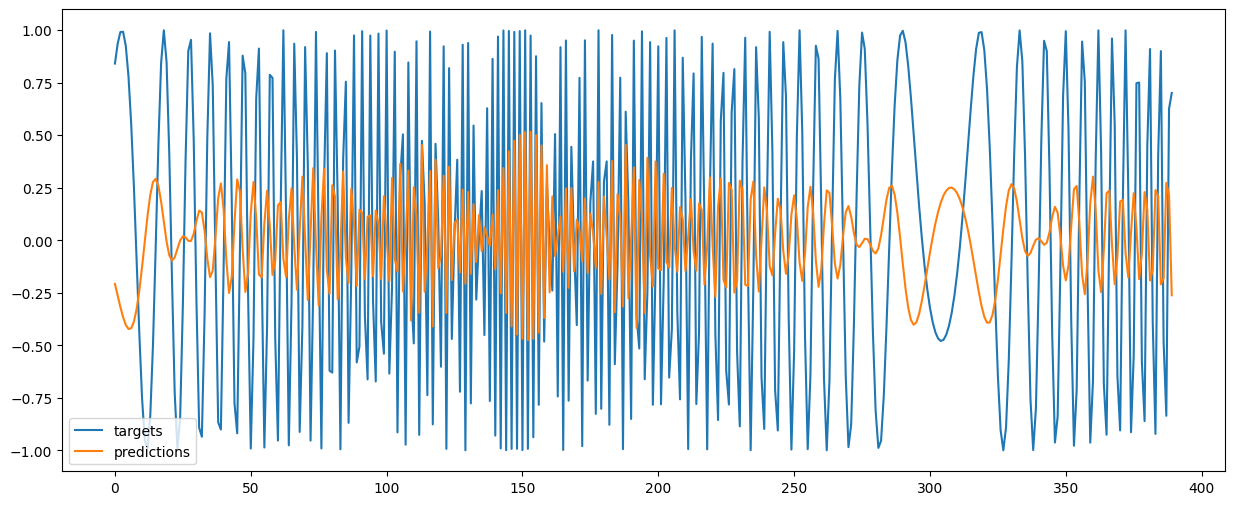

In [43]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]
print(predictions.shape)

plt.figure(figsize=(15, 6))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

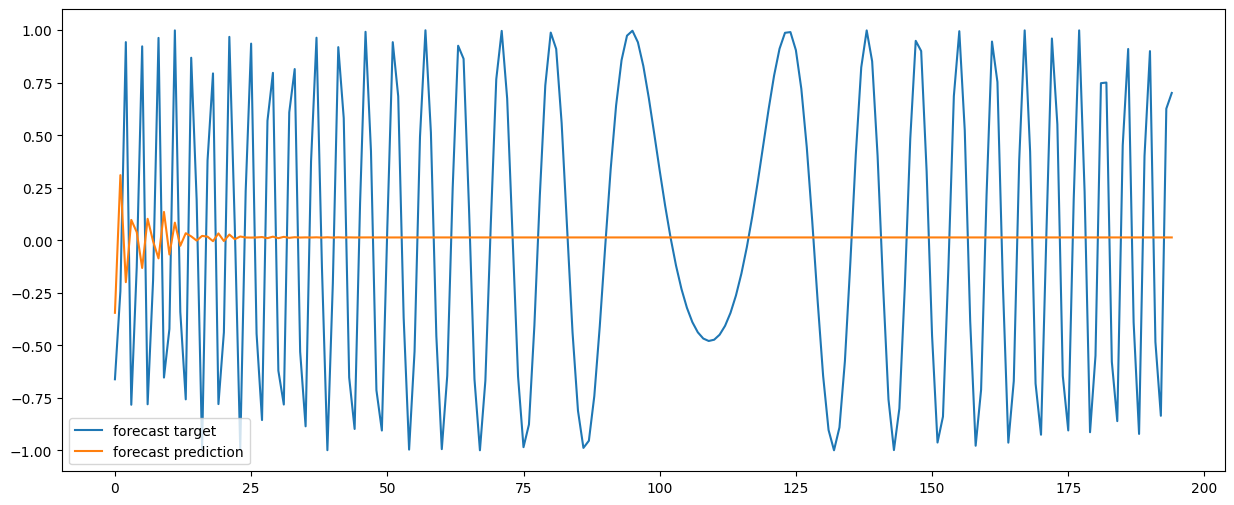

In [44]:
# Multi-step forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1), verbose=0)[0, 0]

    validation_predictions.append(p)

    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.figure(figsize=(15, 6))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

In [45]:
# Now try an LSTM model
X = X.reshape(-1, T, D)

i = layers.Input(shape=(T, D))
# x = layers.SimpleRNN(10)(i)
x = layers.LSTM(10)(i)
x = layers.Dense(1)(x)
model = models.Model(i, x)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.05),
    loss='mse'
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

r_lstm = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size=32,
    epochs=100,
    validation_data=(X[-N//2:], Y[-N//2:]),
    callbacks=[early_stopping_cb],
    verbose=0,
)

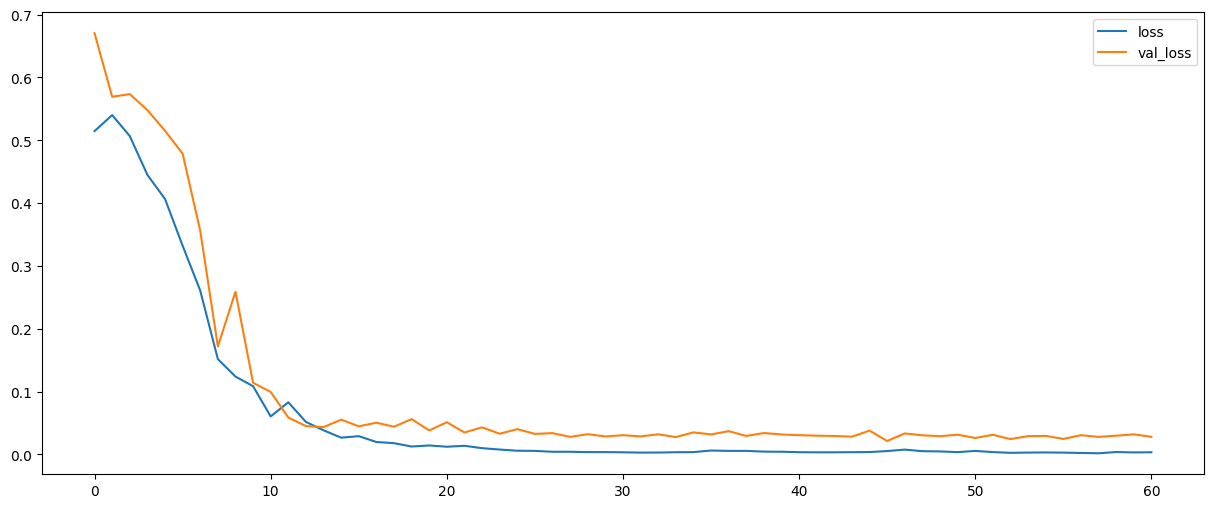

In [46]:
plt.figure(figsize=(15, 6))
plt.plot(r_lstm.history['loss'], label='loss')
plt.plot(r_lstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)
(390,)


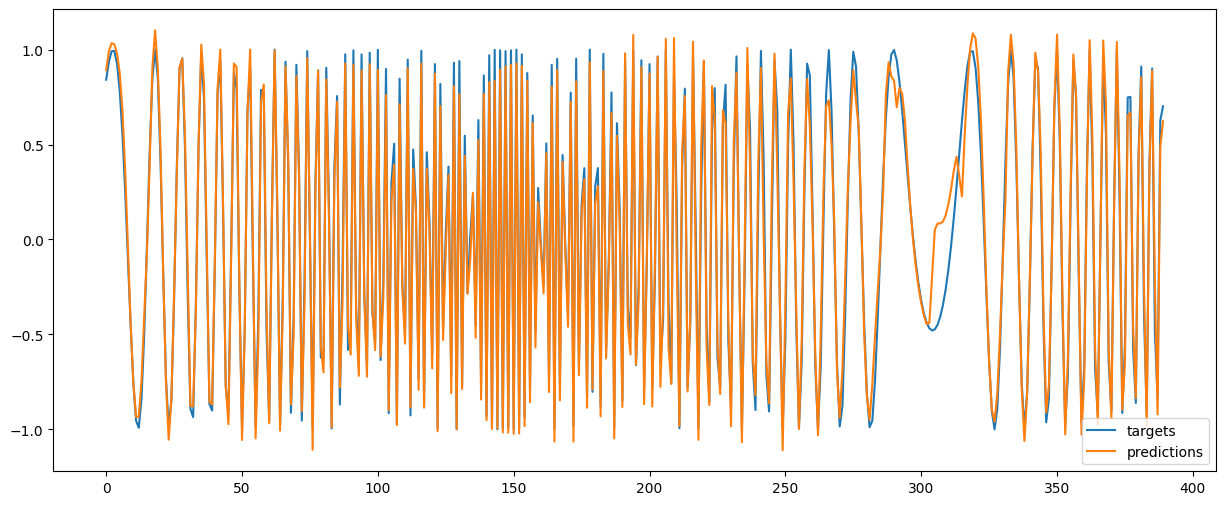

In [47]:
# One-step forecast using true targets
outputs = model.predict(X, verbose=0)
print(outputs.shape)
predictions = outputs[:, 0]
print(predictions.shape)

plt.figure(figsize=(15, 6))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

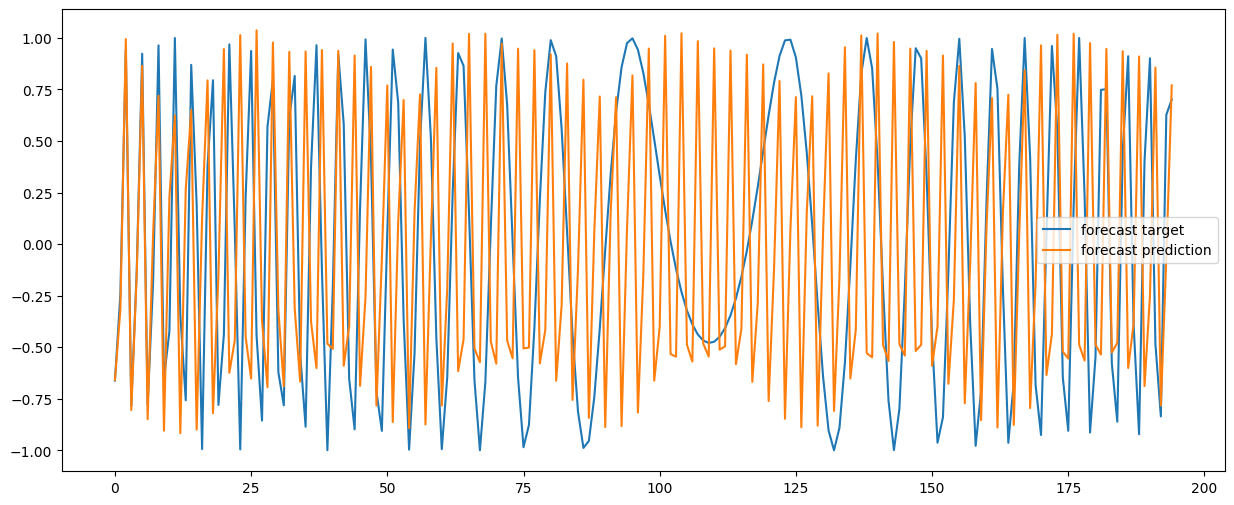

In [48]:
# Multi-step forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1), verbose=0)[0, 0]

    validation_predictions.append(p)

    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.figure(figsize=(15, 6))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()